In [3]:
import pandas as pd

def read_excel_columns(file_path):
    # Load the specific sheet named 'citations' into a DataFrame
    try:
        df = pd.read_excel(file_path, sheet_name='citations')  # Specify the sheet name

        # Extract column names
        column_names = df.columns.tolist()

        # Print the column names
        print("Columns in the 'citations' sheet of the Excel file:")
        for column in column_names:
            print(column)

        # Print the first 5 rows of the DataFrame
        print("\nFirst 5 rows of the 'citations' sheet:")
        print(df.head())  # Prints the first 5 rows of the dataframe

        return column_names
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")

# Example usage
file_path = r"/Users/aakankshahome/Downloads/enterprise-attack-v15.1-groups.xlsx"  # Replace with your actual file path
columns = read_excel_columns(file_path)


Columns in the 'citations' sheet of the Excel file:
reference
citation
url

First 5 rows of the 'citations' sheet:
                               reference  \
0                   360 Machete Sep 2020   
1  ANSSI Nobelium Phishing December 2021   
2            ANSSI Sandworm January 2021   
3                APT15 Intezer June 2018   
4          APT3 Adversary Emulation Plan   

                                            citation  \
0  kate. (2020, September 25). APT-C-43 steals Ve...   
1  ANSSI. (2021, December 6). PHISHING CAMPAIGNS ...   
2  ANSSI. (2021, January 27). SANDWORM INTRUSION ...   
3  Rosenberg, J. (2018, June 14). MirageFox: APT1...   
4  Korban, C, et al. (2017, September). APT3 Adve...   

                                                 url  
0  https://blog.360totalsecurity.com/en/apt-c-43-...  
1  https://www.cert.ssi.gouv.fr/uploads/CERTFR-20...  
2  https://www.cert.ssi.gouv.fr/uploads/CERTFR-20...  
3  https://web.archive.org/web/20180615122133/htt...  
4  https

In [4]:
pip install parsedatetime

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import parsedatetime
from datetime import datetime
import json

def extract_dates_from_citations(df):
    # Initialize a dictionary to store the results
    url_date_dict = {}
    cal = parsedatetime.Calendar()

    # Iterate through the rows of the dataframe
    for index, row in df.iterrows():
        url = row['url']
        citation = row['citation']

        # Use parsedatetime to extract date from the citation
        parsed_date, _ = cal.parse(citation)

        if parsed_date:
            # Format the date as YYYY-MM-DD
            extracted_date = datetime(*parsed_date[:6]).date()
            url_date_dict[url] = {'date': extracted_date, 'download_sha256': None}  # Initialize with empty download_sha256
        else:
            url_date_dict[url] = {'date': None, 'download_sha256': None}  # If no date is found, set date as None

    return url_date_dict


def add_sha256_from_jsonl(jsonl_file_path, url_date_dict):
    # Open and read the JSONL file
    try:
        with open(jsonl_file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                url = entry.get('url')
                download_sha256 = entry.get('download_sha256')

                if url in url_date_dict:
                    # Add download_sha256 to the existing entry in url_date_dict
                    url_date_dict[url]['download_sha256'] = download_sha256
    except Exception as e:
        print(f"An error occurred while reading the JSONL file: {e}")


# Example usage
file_path = r"/Users/aakankshahome/Downloads/enterprise-attack-v15.1-groups.xlsx"  # Replace with your actual file path
jsonl_file_path = r"/Users/aakankshahome/Downloads/downloads/20241008_downloads.jsonl"  # Replace with the actual JSONL file path

# Load the 'citations' sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name='citations')

# Extract the URL-date dictionary
url_date_dict = extract_dates_from_citations(df)

# Add the download_sha256 from the JSONL file to the dictionary
add_sha256_from_jsonl(jsonl_file_path, url_date_dict)

# Print the modified dictionary
print(len(url_date_dict))

#print(url_date_dict)

906


In [30]:
#print(url_date_dict)

In [49]:
import os
import re

def count_unique_ttps_in_file(file_path):
    """
    Extract unique TTPs from a single IOC file using regex.
    Returns the count of unique TTPs found in the file.
    """
    ttp_pattern = re.compile(r'\bT\d{4}(?:\.\d+)?\b')  # Regex to capture TTP IDs
    ttp_set = set()  # To store unique TTPs

    # Verify the file exists
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")  # Debugging message
        return 0  # Return 0 if the file does not exist

    # Open and read the IOC file
    with open(file_path, 'r') as file:
        for line in file:
            matches = ttp_pattern.findall(line)  # Find all TTPs in the line
            ttp_set.update(matches)  # Add found TTPs to the set

    # Return the count of unique TTPs
    return len(ttp_set)

def update_url_date_dict_with_ttp_count(url_date_dict, folder_path):
    """
    Updates the url_date_dict by adding the TTP count for each URL.
    If the corresponding IOC file is not found, sets the TTP count to None.
    """
    # Iterate through the URL dictionary
    for url, data in url_date_dict.items():
        download_sha256 = data.get('download_sha256')

        if download_sha256:
            # Construct the corresponding IOC file name with '.download.iocs' extension
            iocs_file_path = os.path.join(folder_path, f"{download_sha256}.download.iocs")

            # Debugging: Print the path being checked
            #print(f"Checking for IOC file: {iocs_file_path}")

            # Check if the IOC file exists
            if os.path.isfile(iocs_file_path):
                # If the IOC file exists, count the TTPs in the file
                ttp_count = count_unique_ttps_in_file(iocs_file_path)
                #print(ttp_count)
                url_date_dict[url].update({"ttp_count": ttp_count})
            else:
                # If the IOC file doesn't exist, set the TTP count to None
                #print(f"IOC file not found for URL {url}: {iocs_file_path}")  # Debug print for missing files
                url_date_dict[url].update({"ttp_count": None})

    return url_date_dict

# Example usage:
folder_path = r"/Users/aakankshahome/Downloads/downloads/20241008_downloads/iocs2"  # Updated folder path


# Update the URL date dictionary with TTP counts
updated_url_date_dict = update_url_date_dict_with_ttp_count(url_date_dict, folder_path)
print(len(updated_url_date_dict))
# You can now work with updated_url_date_dict as needed.


906


In [50]:
# Extract elements where ttp_count is not None, checking if the key exists
filtered_url_date_dict = {url: data for url, data in updated_url_date_dict.items() if data.get('ttp_count') is not None}

# Print the filtered dictionary (optional)
print(len(filtered_url_date_dict))


103


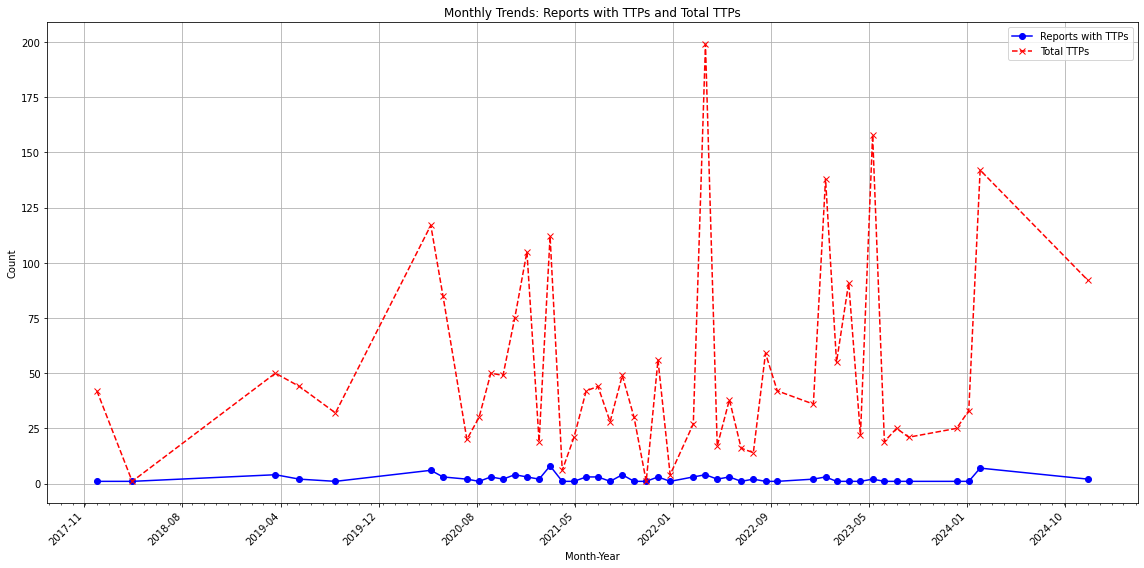

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

# Step 1: Prepare the data for plotting
monthly_data = defaultdict(lambda: {'report_count': 0, 'ttp_count': 0})

# Aggregate data by month
for url, data in filtered_url_date_dict.items():
    report_date = data['date']
    ttp_count = data['ttp_count']
    
    # Use the first day of the month as the key
    month_key = report_date.replace(day=1)
    
    monthly_data[month_key]['report_count'] += 1
    monthly_data[month_key]['ttp_count'] += ttp_count

# Step 2: Prepare data for plotting
months = sorted(monthly_data.keys())  # Get sorted months (x-axis)
report_counts = [monthly_data[month]['report_count'] for month in months]
ttp_counts = [monthly_data[month]['ttp_count'] for month in months]

# Step 3: Plot the data
plt.figure(figsize=(16, 8))

# Plot line for number of reports (with markers)
plt.plot(months, report_counts, marker='o', linestyle='-', color='b', label="Reports with TTPs")

# Plot line for total TTPs per month (with different marker and line style)
plt.plot(months, ttp_counts, marker='x', linestyle='--', color='r', label="Total TTPs")

# Customize the x-axis with months formatted as 'YYYY-MM'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year-Month
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Add minor ticks for better spacing

# Set the x-axis to show fewer labels to avoid squeezing
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=12))  # Limit to 12 ticks to spread them evenly

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Labels and title
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Monthly Trends: Reports with TTPs and Total TTPs')

# Add grid, legends, and adjust layout
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
